## Preamble

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 
import corner 

from matplotlib.patches import Ellipse

In [3]:
#directories that would be using 
repo = '/Users/Ismael/code/lensing/SMFF/'
os.chdir(repo)

In [4]:
#colormap default to use for galaxy 
cmap = 'bwr'

In [5]:
def showImage(image,ax=None,extent=None,vmin=None,vmax=None,origin=None):
    
    if vmin == None: 
        vmin = -abs(image).max()
    if vmax == None: 
        vmax = abs(image).max()
    
    
    if ax is None: 
        return plt.imshow(image, cmap=cmap,vmax=vmax,vmin=vmin,interpolation='None',origin=origin, extent=extent)
    else: 
        return ax.imshow(image, cmap=cmap,vmax=vmax,vmin=vmin,interpolation='None',origin=origin,extent=extent)

In [6]:
def plot_matrix(matrix, param_names): 

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    n,_ = matrix.shape #assume square matrix
    plt.xticks(list(plt.xticks()[0]), [None] + param_names)
    plt.yticks(list(plt.yticks()[0]), [None] + param_names)
    
    plt.tick_params(labelsize=20)


    ax.matshow(matrix, cmap=plt.cm.Blues)


    for i in xrange(n):
        for j in xrange(n):
            c = matrix[j,i]
            ax.text(i, j, '{:.2g}'.format(c), va='center', ha='center',size=20)

In [7]:
latex_names =[r'$\rm{flux}$','$x_{0}$','$y_{0}$',r'$\rm{HLR}$','$e_{1}$','$e_{2}$']

In [8]:
#plotting constants
LINEWIDTH = 2
AXIS_NUMBER_SIZE = 45 
AXIS_LABEL_SIZE = 55 
AXIS_WIDTH = 3
AXIS_LENGTH = 12

FIG_SIZE = 40 

MARKER_SIZE = 14
LINE_WIDTH = 5

## Plots for a single galaxy 

### Generating a galaxy file 

In [9]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'psf_gaussian'
e1 = 0.2
e2 = 0.2
hlr = 1.0 
psf_fwhm = .7
snr = 20. 

#project folder name where you want to write galaxy information 
project1 = 'project-tutoria145'

#image parameters 
pixel_scale=.2 
nx = 40
ny = 40 



In [10]:
cmd = 'python generate.py -p {0} -gal 1 --galaxy-model {1} --psf_model {2}  --e1 {3} --e2 {4} --y0 0 --x0 0 \
--flux 1. --psf_flux 1. --hlr {5} --psf_fwhm {6} --snr {7}'.format(project1,model,psf_model,e1,e2,hlr,psf_fwhm,snr)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print output

### Get fisher formalism analysis from the file

In [11]:
import analysis.fisher as fisher
import analysis.galfun as galfun

In [12]:
g_parameters = galfun.GParameters(project1) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

### Draw galaxy generated 

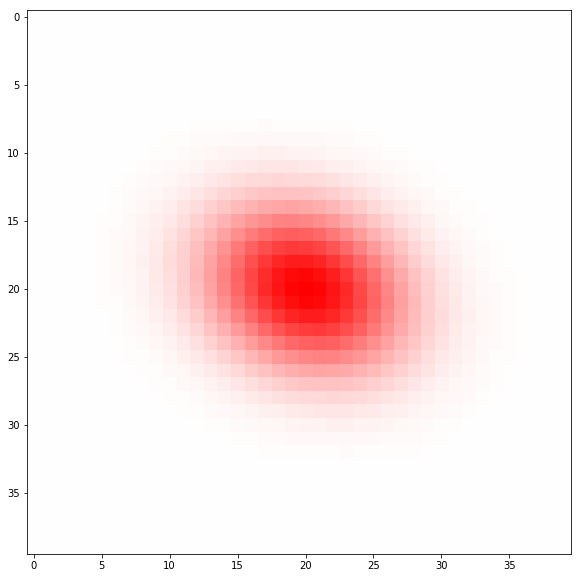

In [13]:
#get galaxy image and display it from fisher object. green is positive and red is negative 
fig = plt.figure(figsize=(10,10))
showImage(fish.image.array)


### Display derivatives 

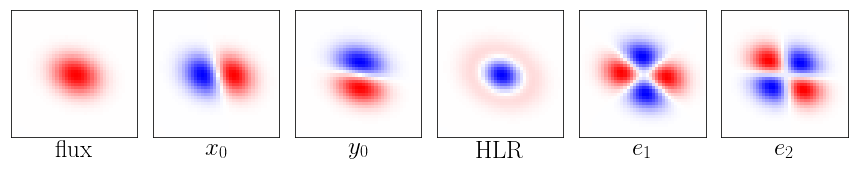

In [14]:
#draw partials.
nrow,ncol = 1,6
fig = plt.figure(figsize=(15,15))
plt.rc('text', usetex=True)
for i,name in enumerate(fish.param_names):
    image = fish.derivatives_images[name]
    plt.subplot(nrow,ncol,i+1)
    showImage(image)
    #plt.title('Partial derivative with respect to {0}'.format(name[:-2]),fontsize=14)
    #plt.colorbar()
    plt.tick_params(
    axis='both',     
    which='both',      
    bottom='off',   
    top='off',        
    left='off',
    labelleft='off',
    right='off',
    labelbottom='off')
    plt.xlabel(latex_names[i],size=25)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.125, hspace=.1)


### Display fisher matrix 


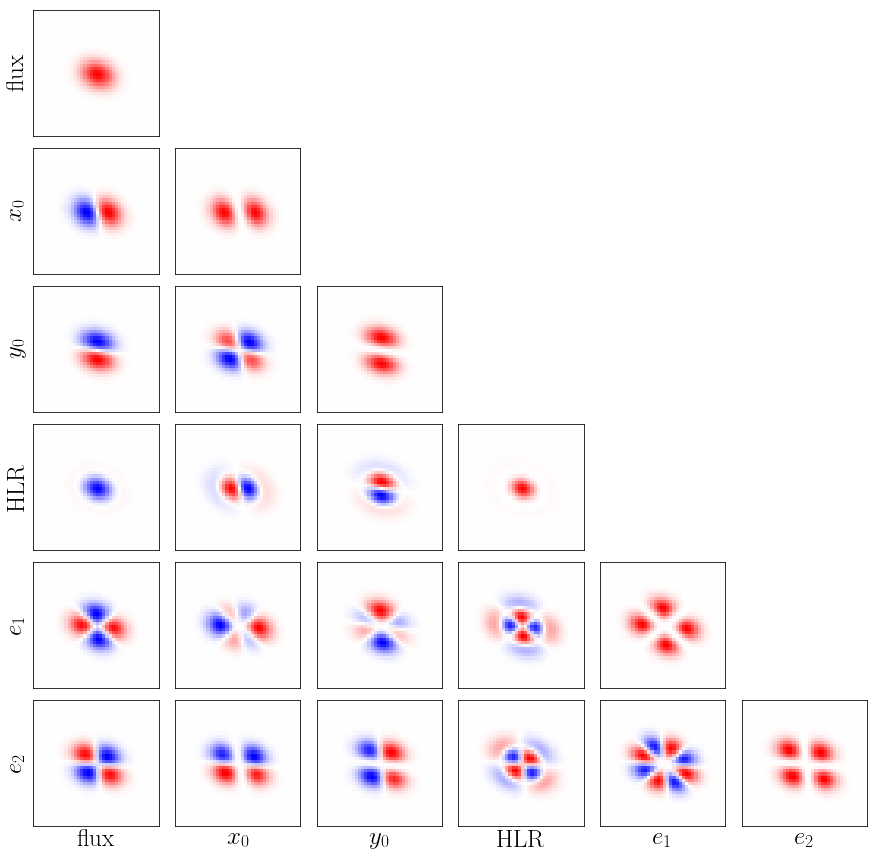

In [15]:
figure = plt.figure(figsize=(15,15))
# figure.suptitle('Fisher matrix elements',
#                 fontsize=20)
for i in range(fish.num_params):
    for j in range(fish.num_params):
        if i >= j:
            ax = figure.add_subplot(fish.num_params,
                                    fish.num_params,
                                    fish.num_params * i + j + 1)
            showImage(fish.fisher_matrix_images[
                          fish.param_names[i],
                          fish.param_names[j]
                      ],ax)
            
                 
            if j == 0: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom='off',   
                top='off',        
                left='off',
                labelleft='off',
                right='off',
                labelbottom='off')
                plt.ylabel(latex_names[i],size=25)
            if i == fish.num_params-1: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom='off',   
                top='off',        
                left='off',
                labelleft='off',
                right='off',
                labelbottom='off')
                plt.xlabel(latex_names[j],size=25)
            if i!= 0 and j!= fish.num_params-1: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom='off',   
                top='off',        
                left='off',
                labelleft='off',
                right='off',
                labelbottom='off')
            plt.rc('text', usetex=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.1, hspace=.1)


## Draw bias plot per pixel 

In [16]:
param_names = ['flux_1', 'x0_1',  'e1_1', 'hlr_1',  'y0_1',  'e2_1']
clatex_names= [r'$\rm{flux}$', '$x_{0}$', '$e_{1}$',r'$\rm{HLR}$','$y_{0}$','$e_{2}$']

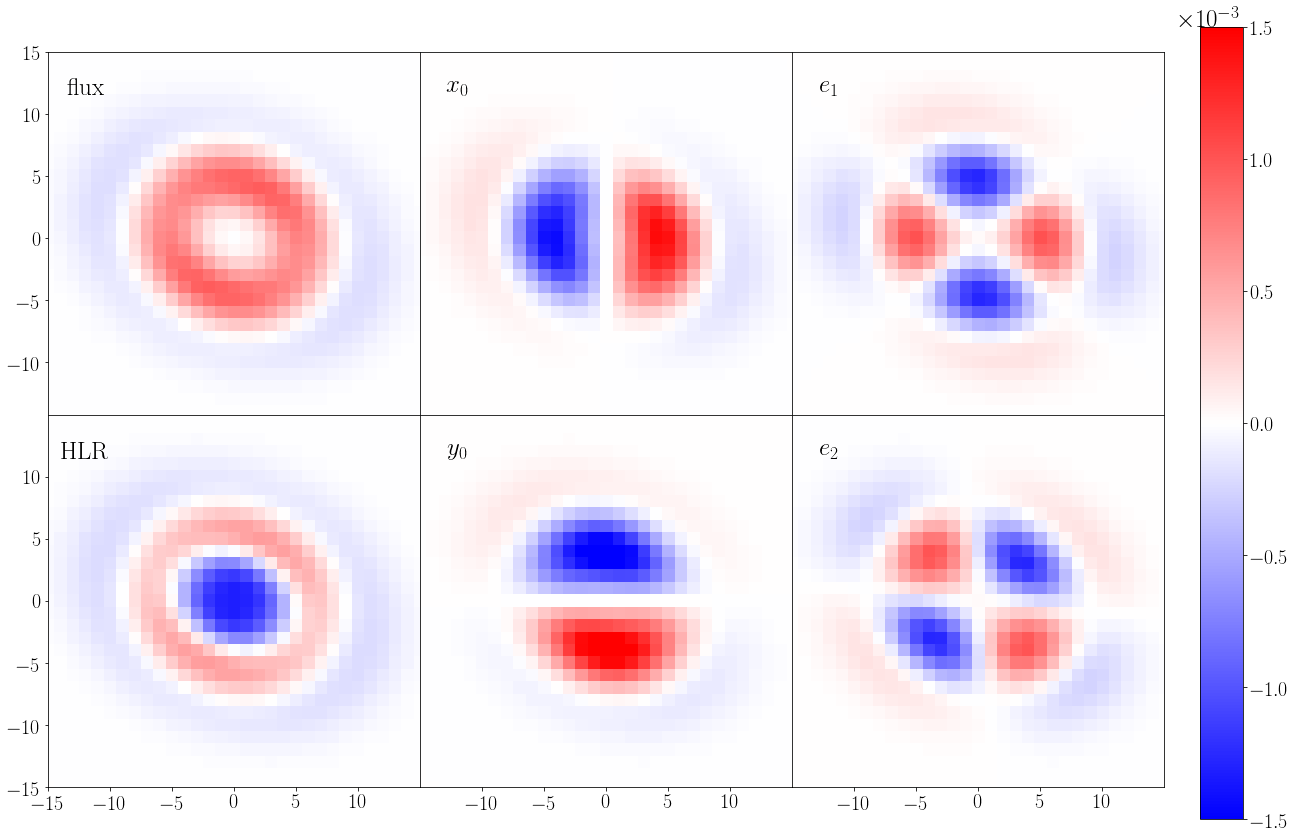

In [22]:
#draw bias images.
plt.rc('text', usetex=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable

nrow,ncol = 2,3
fig = plt.figure(figsize=(20,20))
for i,name in enumerate(param_names):
    image = fish.bias_images[name] /np.sqrt(fish.covariance_matrix[name,name])
    ax = plt.subplot(nrow,ncol,i+1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim((-15,15))
    plt.ylim((-15,15))

    if i==3: 
        plt.xticks([-15, -10, -5, 0, 5, 10], ['$-15$', '$-10$', '$-5$', '$0$', '$5$', '$10$'])
        
    else: 
        plt.xticks([-10, -5, 0, 5, 10], ['$-10$', '$-5$', '$0$', '$5$', '$10$'])
    
    if i==0: 
        plt.yticks([-10, -5, 0, 5, 10, 15], ['$-10$', '$-5$', '$0$', '$5$', '$10$', '$15$'])
    else: 
        plt.yticks([-15, -10, -5, 0, 5, 10], ['$-15$', '$-10$', '$-5$', '$0$', '$5$', '$10$'])
    

    
    if i == 0: 
        plt.tick_params(
        axis='both',     
        which='both',      
        bottom='off',   
        top='off',        
        left='on',
        labelleft='on',
        right='off',
        labelbottom='off')
    
    if i in [1,2]: 
        plt.tick_params(
        axis='both',     
        which='both',      
        bottom='off',   
        top='off',        
        left='off',
        labelleft='off',
        right='off',
        labelbottom='off')    
        
        
    if i in [4,5]: 
        plt.tick_params(
        axis='both',     
        which='both',      
        bottom='on',   
        top='off',        
        left='off',
        labelleft='off',
        right='off',
        labelbottom='on')  

    im = showImage(image,vmin=-.0015,vmax=.0015,extent=[-20.5,19.5,-19.5,20.5])
    plt.text(.1,.9,'${0}$'.format(clatex_names[i]),fontsize=25,ha='center', va='center', transform=ax.transAxes,fontweight='bold')
    

#several formatting settings for the colorbar. 
cbar_ax = fig.add_axes([0.925, 0.225, 0.03, 0.55])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20) 
cbar.ax.get_yaxis().get_offset_text().set_size(25)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=-.5)


### Bias as a function of size 

In [25]:
# snr_norm = 20 #nominal snr to use. 
def bias_Size(fish,image_renderer,params, num_params):
    """Plot of bias*(snr_norm/snr)**2 as a function of hlr/psf_fwhm with a fixed snr."""
    
    plt.rc('text', usetex=True)

    steps = 25
    x_range = (.2, 1.5)  # x = hlr_gal / psf_fwhm
    xs = np.linspace(x_range[0], x_range[1], steps)
    figure = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
    id_params = deepcopy(fish.g_parameters.id_params)
    snr_norm = fish.snr #normally use 20.
    ys = {} # y= bias*snr^2
    for x in xs:
        gal_id = id_params.keys()[0]
        hlr = x * id_params[gal_id]['psf_fwhm']
        id_params[gal_id]['hlr'] = hlr
        g_parameters = galfun.GParameters(id_params=id_params)
        new_fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases = new_fish.biases
        for i,param in enumerate(params):
            if param not in ys:
                ys[param] = []
            bias = biases[param]
            y = bias
            ys[param].append(y)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.28, hspace=None)



    #do not plot x0 and y0
    extra = r'$\, \left(' + str(int(snr_norm)) + r'/\rm{SNR}\right)^{2}$'
    y_names = [r'$b(\rm{flux})$',
                r'$b(\rm{HLR})$', r'$b(e_{1})$',
                r'$b(e_{2})$']
    units = [r'$10^{-3}$',r'$10^{-2} \, \rm{arcseconds}$', '$10^{-2}$', '$10^{-2}$']
    y_titles = [elt + extra + '  [{0}]'.format(unit) for elt,unit in zip(y_names,units)]
    x_titles = [r'\rm{HLR/FWHM}$_{\rm{PSF}}$'] * 6
    ranges_x = [None,[0,1.6],[0,1.6],[0,1.6]]
    ranges_y = [[-1e-3,6e-3],None,None,None]
    for i,param in enumerate(params):
        ax = figure.add_subplot(2, num_params / 2,
                                i + 1)
        
        ax.plot(xs, ys[param],'-o',linewidth=LINE_WIDTH,markersize=MARKER_SIZE)
        ax.set_xticks(np.linspace(0,1.6,5)) 
        ax.set_xlabel(x_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel(y_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.tick_params(labelsize=AXIS_NUMBER_SIZE)
        ax.get_yaxis().get_offset_text().set_size(1)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
        
        ax.tick_params(which='both', width=AXIS_WIDTH,length=AXIS_LENGTH)
        
        
        plt.axhline(0,color='r')
        if ranges_x[i] != None: plt.xlim(ranges_x[i])
        if ranges_y[i] != None: plt.ylim(ranges_y[i])



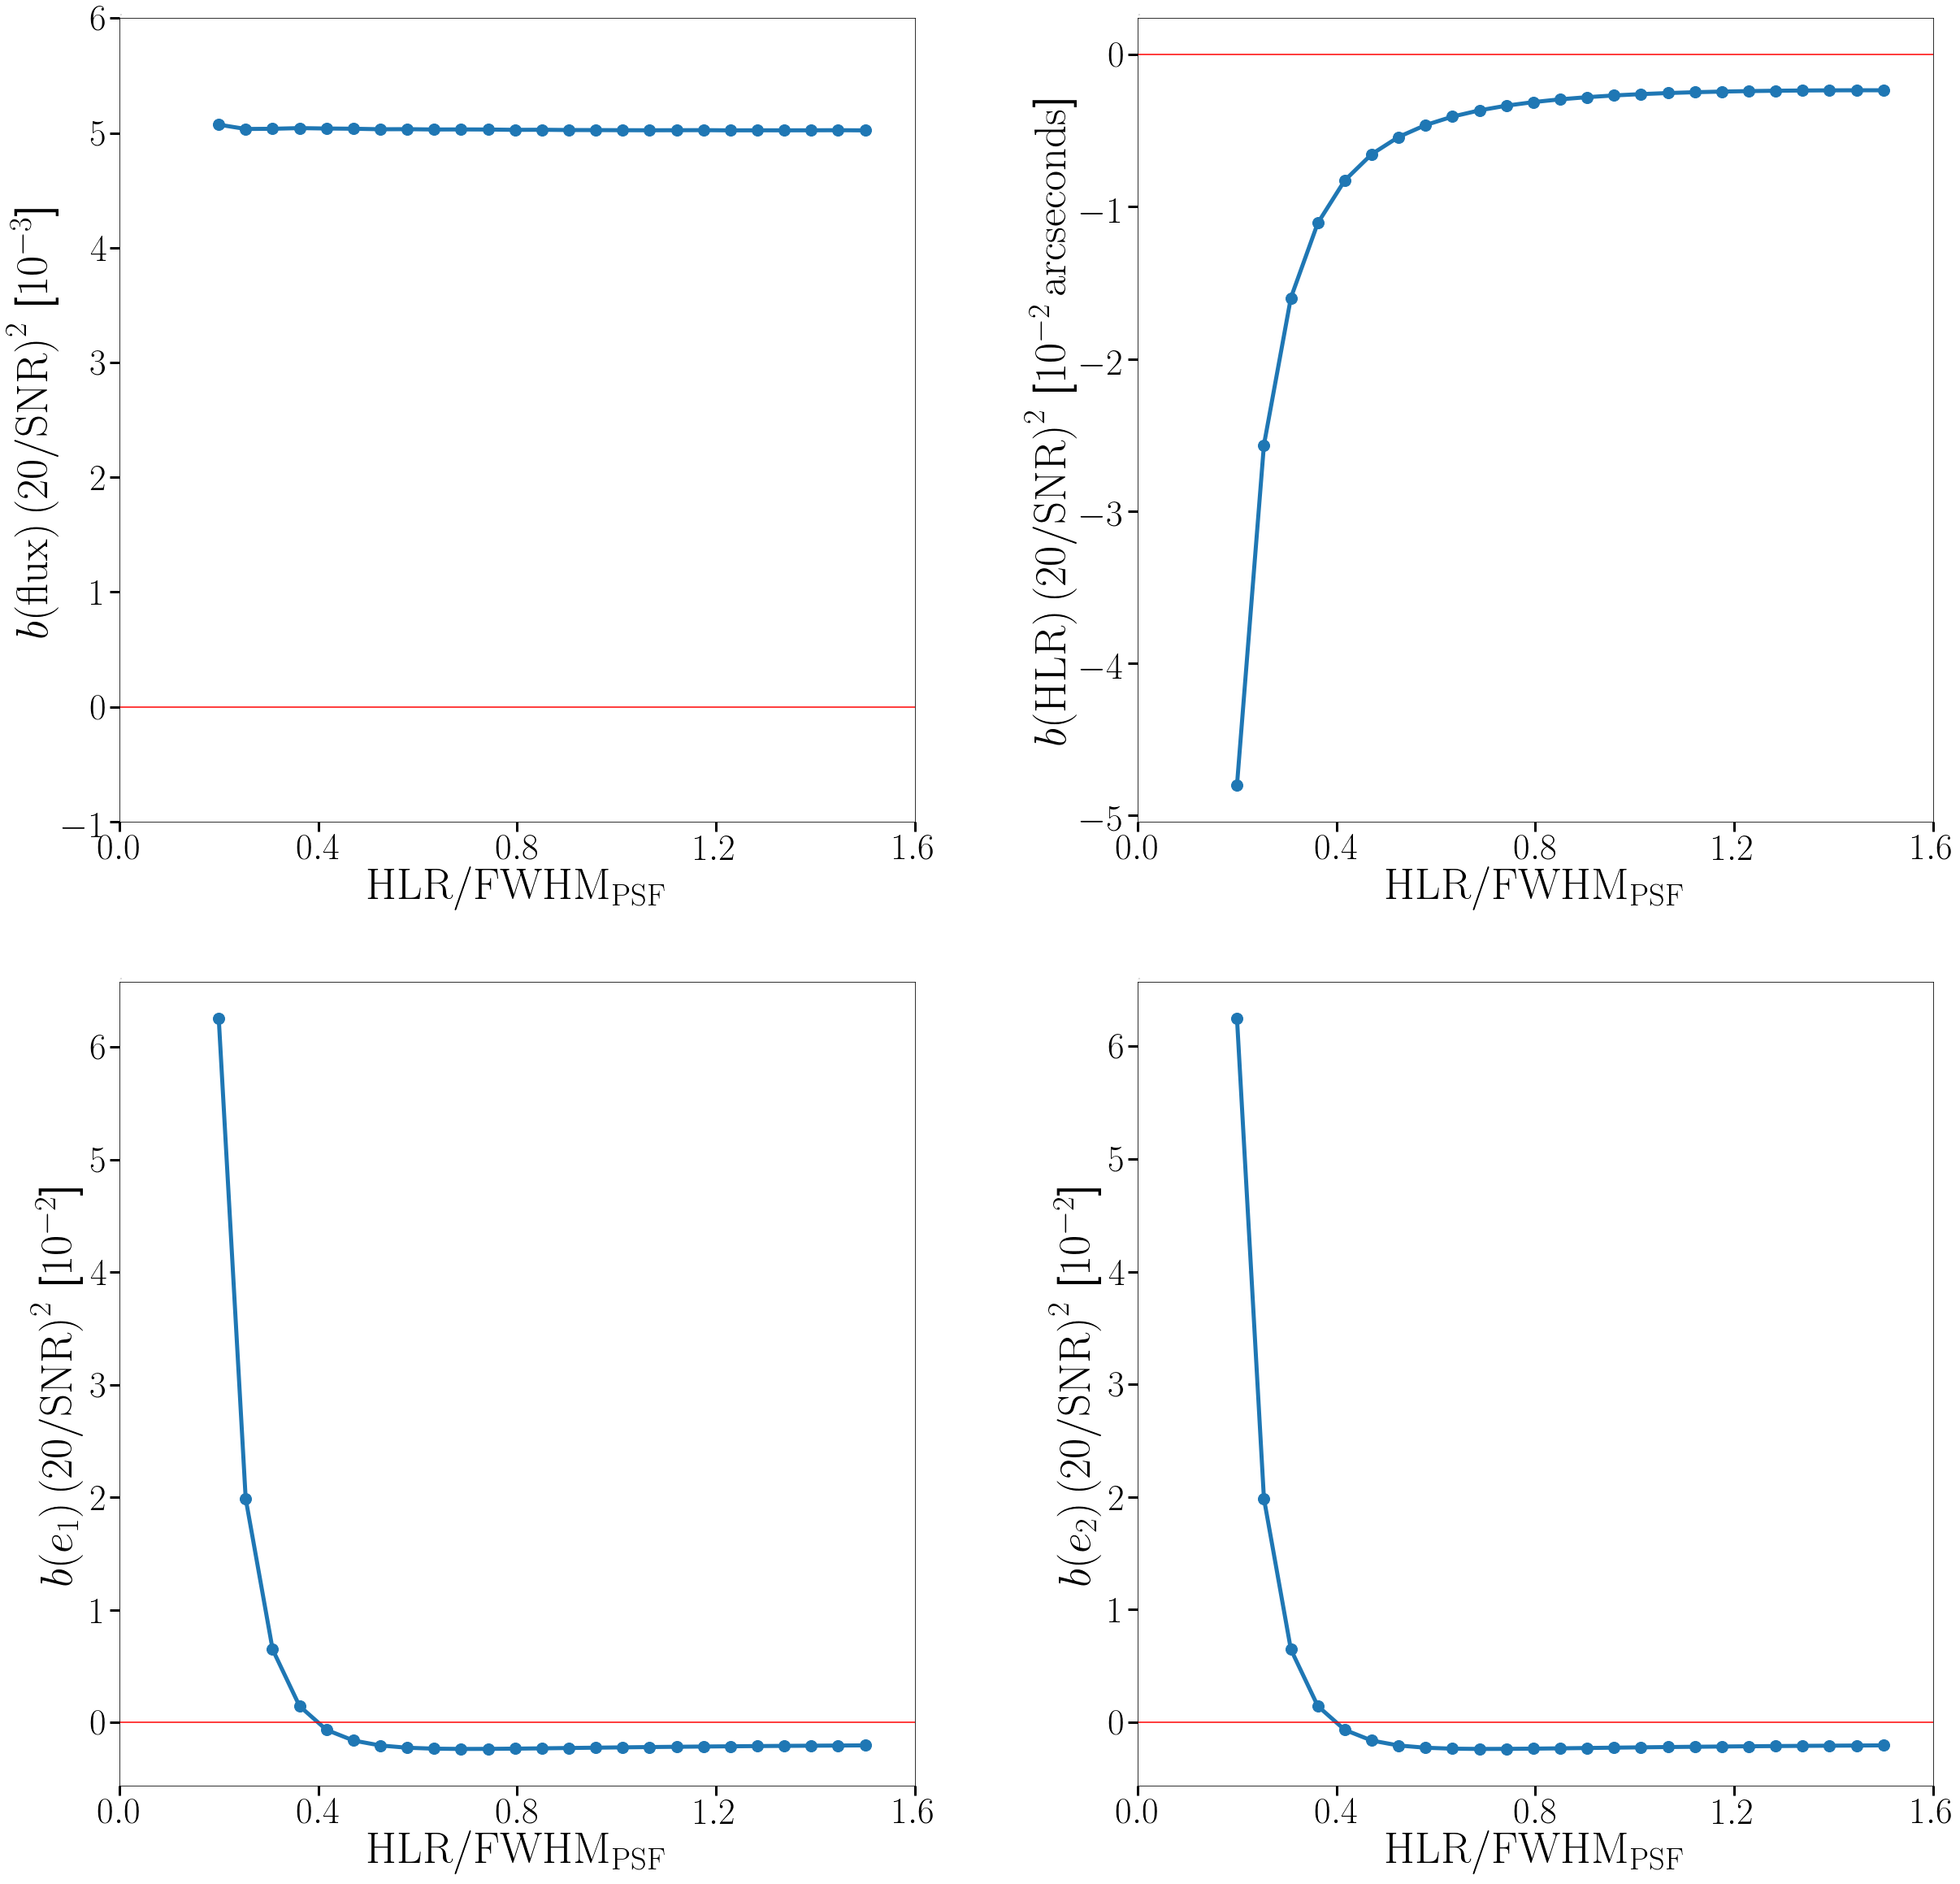

In [26]:
params = [fish.param_names[0]] + fish.param_names[3:] #want flux and not x0,y0
bias_Size(fish,image_renderer,params, fish.num_params-2)

### Bias as a function of ellpticity 

In [27]:
#bias on parameters as a function of a component of ellipticity.
snr_norm = 20
def bias_ellipticity(fish,image_renderer,params, num_params):
    """Plot of bias*(snr_norm/snr)**2 as a function of e1 (all other parameters fixed.)"""

    plt.rc('text', usetex=True)
    steps = 30
    x_range = (-.9, .9)  #x = e1 
    xs = np.linspace(x_range[0], x_range[1], steps)
    figure = plt.figure(figsize=(FIG_SIZE, FIG_SIZE))
    id_params = deepcopy(fish.g_parameters.id_params)
    ys = {} # y= bias*snr2
    for x in xs:
        gal_id = id_params.keys()[0]
        id_params[gal_id]['e1'] = x
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases = fish.biases
        for i,param in enumerate(params):
            if param not in ys:
                ys[param] = []
            bias = biases[param]
            ys[param].append(bias)


    #do not plot x0 and y0
    units = ['$10^{-2}$',r'$10^{-3}$\,$\rm{arcseconds}$', '$10^{-3}$', '$10^{-3}$']
    extra = r'$\, \left(' + str(snr_norm) + r'/\rm{SNR}\right)^{2}$'
    y_names = [r'$b(\rm{flux})$',
                r'$b(\rm{HLR})$', r'$b(e_{1})$',
                r'$b(e_{2})$']
    y_titles = [elt + extra + "  [{0}]".format(unit) for (elt,unit) in zip(y_names,units)]
    x_titles = [r'$e_{1}$'] * 4
    for i,param in enumerate(params):
        ax = figure.add_subplot(2, num_params / 2,
                                i + 1)
        ax.plot(xs, ys[param],'-o', markersize=MARKER_SIZE,linewidth=LINE_WIDTH)
        ax.set_xlabel(x_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.set_ylabel(y_titles[i], fontsize=AXIS_LABEL_SIZE)
        ax.tick_params(labelsize=AXIS_NUMBER_SIZE)
        ax.tick_params(which='both', width=AXIS_WIDTH,length = AXIS_LENGTH)
        ax.set_xticks(np.linspace(-.9,.9,5)) 
        ax.get_yaxis().get_offset_text().set_size(1)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
        
        plt.axhline(0,color='r')


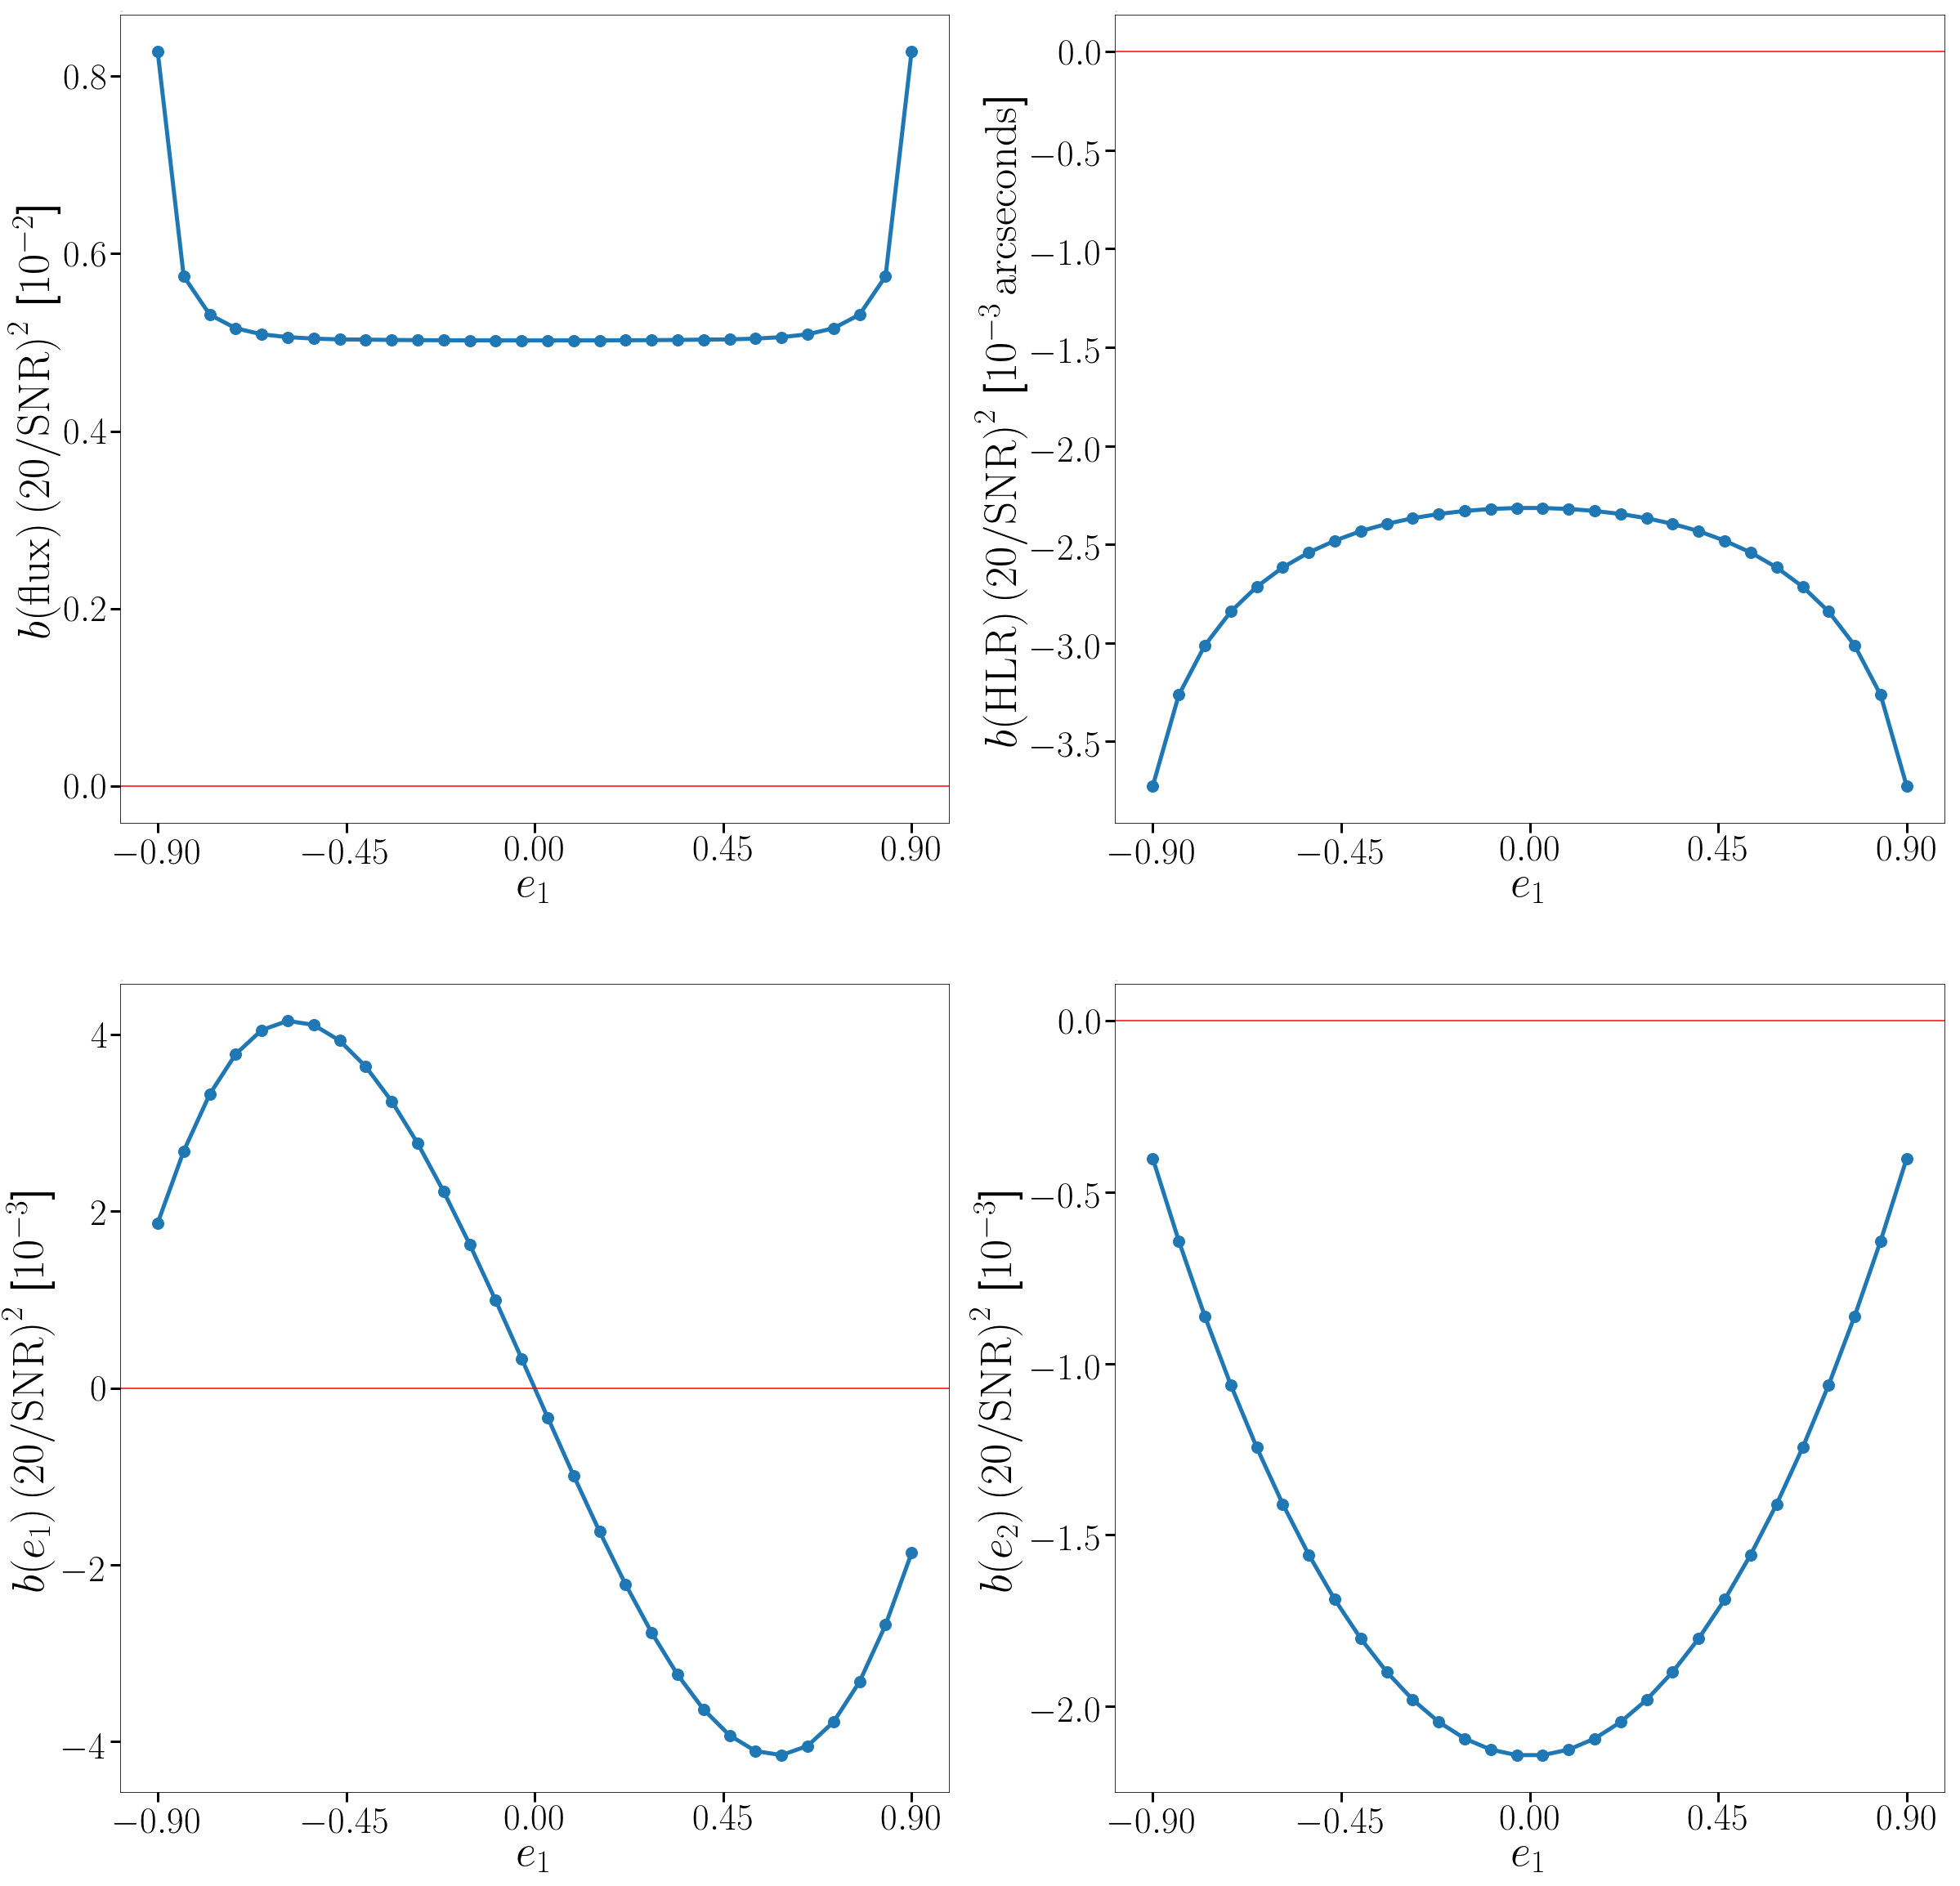

In [28]:
params = [fish.param_names[0]] + fish.param_names[3:] #want flux and not x0,y0
bias_ellipticity(fish,image_renderer,params, fish.num_params-2)